# Linear Regression in TensorFlow

## Import Packages

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
tf.__version__

'2.0.0-beta1'

## Loading Data & Preprocessing


In [3]:
%%bigquery flights_df --verbose
SELECT date,
       airline,
       departure_airport,
       arrival_airport,
       departure_lat,
       departure_lon,
       arrival_lat,
       arrival_lon,
       departure_delay,
       arrival_delay
FROM `bigquery-samples.airline_ontime_data.flights`
Where departure_airport = 'SFO' AND date >= '2009-01-01' AND date <= '2009-12-31'

Executing query with job ID: f6bc7ff4-1cec-4f38-8648-7cc8fb55d5a3
Query executing: 0.50s
Query complete after 0.97s


In [4]:
flights_df.shape

(134990, 10)

In [5]:
flights_df.head()

,date,airline,departure_airport,arrival_airport,departure_lat,departure_lon,arrival_lat,arrival_lon,departure_delay,arrival_delay
0,2009-04-30,NW,SFO,MSP,37.61,-122.37,44.88,-93.22,-8.0,-4.0
1,2009-04-29,NW,SFO,MSP,37.61,-122.37,44.88,-93.22,-7.0,-27.0
2,2009-04-28,NW,SFO,MSP,37.61,-122.37,44.88,-93.22,-5.0,-10.0
3,2009-04-27,NW,SFO,MSP,37.61,-122.37,44.88,-93.22,-9.0,-7.0
4,2009-04-26,NW,SFO,MSP,37.61,-122.37,44.88,-93.22,-3.0,-15.0


In [6]:
flights_processed_df = (flights_df
                        .query('1 <= departure_delay <= 120')
                        .dropna()
                        .filter(['departure_delay', 'arrival_delay'])
                       )

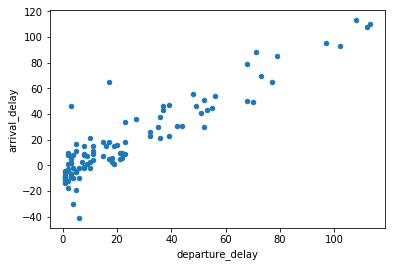

In [7]:
(flights_processed_df
 .sample(n=100, random_state = 123)
 .plot.scatter('departure_delay', 'arrival_delay'))

Let's try to model this using linear regression.

## Simple Linear Regression

### Training-Testing-Split

Split the data into training and testing set. Separate features from labels. Ignore missing values for now.

In [8]:
train_df = flights_processed_df.sample(frac=0.8,random_state=123)
test_df = flights_processed_df.drop(train_df.index)

train_labels = train_df.pop('arrival_delay')
test_labels = test_df.pop('arrival_delay')

### Building the Model

In [9]:
# Initialize a Sequential model using TF.Keras API:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    # Adds a densely-connected layer with 1 unit to the model:
    tf.keras.layers.Dense(1, activation='linear', input_shape = [len(train_df.keys())])
    
])


model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mean_squared_error'],
             )

![](linear_node_1.png)

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


The model has 2 free parameters which is simple regression y = w0*x0 + b. When we compile the model, random weights and no bias will be initialized.

In [11]:
model.get_weights()

[array([[-0.93762565]], dtype=float32), array([0.], dtype=float32)]

### Testing the model architecture

In [12]:
example_batch = train_df[:5]
print(example_batch)

model.predict(example_batch)

        departure_delay
84174               2.0
69887              52.0
36578               5.0
132614             23.0
34780               1.0


array([[ -1.8752513 ],
       [-48.756535  ],
       [ -4.6881285 ],
       [-21.56539   ],
       [ -0.93762565]], dtype=float32)

The model is predicting something. Currently it doesn't make sense, because the model wasn't fitted to the data. But we'll work on that now!

### Training the model

In [13]:
history = model.fit(train_df, train_labels, 
                    epochs=10,
                    callbacks=[tf.keras.callbacks.TensorBoard("logs/simple-regression")])

Train on 38228 samples
Epoch 1/10
38228/38228 [==============================] - 2s 42us/sample - loss: 2984.9891 - mean_absolute_error: 36.1613 - mean_squared_error: 2984.9883
Epoch 2/10
38228/38228 [==============================] - 1s 35us/sample - loss: 349.0500 - mean_absolute_error: 13.1715 - mean_squared_error: 349.0502
Epoch 3/10
38228/38228 [==============================] - 1s 34us/sample - loss: 179.5396 - mean_absolute_error: 10.0204 - mean_squared_error: 179.5396
Epoch 4/10
38228/38228 [==============================] - 1s 34us/sample - loss: 173.8846 - mean_absolute_error: 9.7871 - mean_squared_error: 173.8846
Epoch 5/10
38228/38228 [==============================] - 1s 36us/sample - loss: 169.4330 - mean_absolute_error: 9.6010 - mean_squared_error: 169.4330
Epoch 6/10
38228/38228 [==============================] - 1s 34us/sample - loss: 166.0738 - mean_absolute_error: 9.4520 - mean_squared_error: 166.0739
Epoch 7/10
38228/38228 [==============================] - 1s 33us/

In [14]:
model.get_weights()

[array([[0.9832586]], dtype=float32), array([-4.2184663], dtype=float32)]

See how the model weights were fitted to our data. Let's see how the fitted regression performs:

### Performance evaluation of simple regression on test data

In [15]:
test_predictions = model.predict(test_df).flatten()
results_df = pd.DataFrame({'Predicted': test_predictions, 'Actual': test_labels})
results_df.head(5)

,Actual,Predicted
8,17.0,19.379740
35,-9.0,1.681085
72,5.0,7.580637
95,-9.0,-2.251949
119,19.0,-2.251949


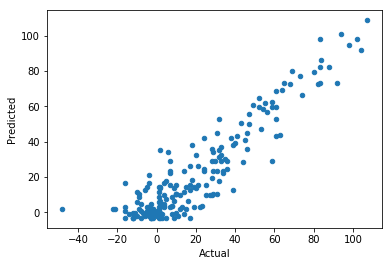

In [16]:
(results_df
 .sample(n=200, random_state = 123)
 .plot.scatter('Actual', 'Predicted')
)

The model still shows a lot of scatter.

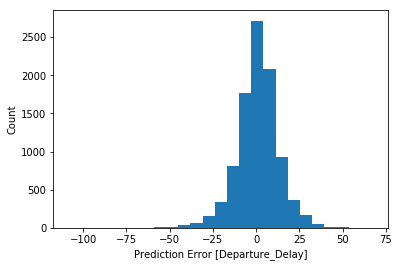

In [17]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Departure_Delay]")
_ = plt.ylabel("Count")

More concretely, our model seems to be a little bit too optimistic about arrival delays. We are predicting less delay than actually observed.

In [18]:
test_mae = abs(error).mean()

test_mae

9.108514994049193

On average, we are missing the true value by about 9 Minutes.

## Multiple Linear Regression

Let's try to improve our model by adding more complexity, i.e. features. Here we will add the distance between the origin and destination airport. 

Unfortunately the dataset does not contain the distance. We have to calculate it from the coordinates.

In [ ]:
pip install geopy

In [19]:
import geopy.distance
coords_1 = (38.94, -77.46)
coords_2 = (40.77, -73.87)

In [20]:
geopy.distance.distance(coords_1, coords_2).km

368.27546093077206

In [21]:
# Calculate distance for each route
def coords_to_distance(row):
    coords_start = (row['departure_lat'], row['departure_lon'])
    coors_end = (row['arrival_lat'], row['arrival_lon'])
    distance = geopy.distance.distance(coords_start, coors_end).km
    return(distance)

def get_route_key(row):
    return row['departure_airport']+row['arrival_airport']

distances_df = (flights_df[['departure_airport', 'arrival_airport', 'departure_lon', 'departure_lat', 'arrival_lon', 'arrival_lat']]
                .drop_duplicates()
                .assign(route_key = get_route_key)
               )
distances_df['distance'] = distances_df.apply(coords_to_distance, axis=1)
distances_df = distances_df[['route_key', 'distance']]

# Add distances to flights_processed_df
flights_processed_df = (flights_df
                        .query('1 <= departure_delay <= 120')
                        .assign(route_key = get_route_key)
                        .merge(distances_df)
                        .dropna()
                        .filter(['departure_delay', 'distance', 'arrival_delay'])
                       )

In [22]:
flights_processed_df.head()

,departure_delay,distance,arrival_delay
0,24.0,2557.17428,17.0
1,1.0,2557.17428,12.0
2,8.0,2557.17428,-5.0
3,9.0,2557.17428,10.0
4,6.0,2557.17428,-9.0


In [23]:
train_df = flights_processed_df.sample(frac=0.8,random_state=123)
test_df = flights_processed_df.drop(train_df.index)

train_labels = train_df.pop('arrival_delay')
test_labels = test_df.pop('arrival_delay')

In [24]:
train_df.head()

,departure_delay,distance
28571,28.0,4057.569368
23431,10.0,3937.662438
12520,17.0,4162.755462
47094,5.0,964.126289
11796,39.0,4162.755462


In [25]:
# Initialize a Sequential model using TF.Keras API:
tf.keras.backend.clear_session()

model = tf.keras.models.Sequential([
    
    # Adds a densely-connected layer with 1 unit to the model:
    tf.keras.layers.Dense(1, activation='linear', input_shape = [len(train_df.keys())])
    
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
              loss='mean_squared_error',
              metrics=['mean_absolute_error', 'mean_squared_error'])

![](linear_node_n.png)

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


Recognize that the model has 3 Parameters now: 1 bias and 2 weights for each input feature.

In [27]:
history = model.fit(train_df, train_labels, 
                    epochs=20,
                    callbacks=[tf.keras.callbacks.TensorBoard("logs/multinominal-regression")])

Train on 38228 samples
Epoch 1/20
38228/38228 [==============================] - 2s 42us/sample - loss: 559349.1240 - mean_absolute_error: 403.1479 - mean_squared_error: 559348.9375
Epoch 2/20
38228/38228 [==============================] - 1s 34us/sample - loss: 328.5479 - mean_absolute_error: 12.7220 - mean_squared_error: 328.5479
Epoch 3/20
38228/38228 [==============================] - 1s 36us/sample - loss: 160.3575 - mean_absolute_error: 9.2418 - mean_squared_error: 160.3576
Epoch 4/20
38228/38228 [==============================] - 1s 34us/sample - loss: 160.1359 - mean_absolute_error: 9.2147 - mean_squared_error: 160.1359
Epoch 5/20
38228/38228 [==============================] - 1s 34us/sample - loss: 159.4031 - mean_absolute_error: 9.1953 - mean_squared_error: 159.4032
Epoch 6/20
38228/38228 [==============================] - 1s 33us/sample - loss: 159.6713 - mean_absolute_error: 9.1827 - mean_squared_error: 159.6713
Epoch 7/20
38228/38228 [==============================] - 1s 3

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

### Performance evaluation of multiple regression on test data

In [28]:
test_mae = abs(error).mean()

test_mae

9.108514994049193

We didn't increase our model performance by just adding another variable.

Are we already overfitting the data? Maybe our linear model can't capture the data?

Let's find out in the next chapter, what we can do to improve our model performance.